# PIERS Data Cleaning

This notebook addresses missing data and other issues in the PIERS BOL data. This work is predominantly exploratory in nature, and some of these processes may eventually move to the ETL step. 

In [34]:
import pandas as pd
import polars as pl
import plotly_express as px
import missingno as msno
from polars.testing import assert_frame_equal

#display settings
pd.set_option('display.max_columns', None)

#enable string cache for polars categoricals
pl.enable_string_cache()

Convenience steps:
- create 2-digit hs codes (note this naievely takes the first two digits from the column, which contains multiple hs codes)
- create year and month (e.g., 202305) columns 
- replace zero values with nulls in volume columns
- create voyage_id from year, vessel IMO code, voyage number, and origin/destination country 
- add direction column showing 'import' or 'export' to allow easy merging
- get most commonly used SCAC and name for each carrier

In [35]:
#set paths
imports_path = 'data/clean/imports/'
exports_path = 'data/clean/exports/'
#init lazy dataframes
imports_lf = (
    pl.scan_parquet(imports_path+'*.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_arrival').dt.year().alias('year'),
        pl.col('date_arrival').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None),
        #create direction column
        pl.lit('import').cast(pl.Categorical).alias('direction')
        ])
    #get most commonly used carrier name for each scac and vise-versa to normalize changes in names and codes 
    .with_columns(
        pl.col('carrier_name').drop_nulls().mode().first().over('carrier_scac')
        .alias('unified_carrier_name')
    )
    .with_columns(
        pl.col('carrier_scac').drop_nulls().mode().first().over('unified_carrier_name')
        .alias('unified_carrier_scac')
    )
    .with_columns(
        #create voyage_id from year, vessel IMO, voyage number, and origin country
        (pl.col('year').cast(pl.Utf8)+'_'+
         pl.col('vessel_id').cast(pl.Utf8)+'_'+
         pl.col('voyage_number').cast(pl.Utf8)+'_'+
         pl.col('origin_territory').cast(pl.Utf8))
        .cast(pl.Categorical).alias('voyage_id')
    )
)
exports_lf = (
    pl.scan_parquet(exports_path+'piers_exports_complete.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_departure').dt.year().alias('year'),
        pl.col('date_departure').dt.strftime('%Y%m').alias('month'),
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None),
        #create direction column
        pl.lit('export').cast(pl.Categorical).alias('direction')
        ])
    #get most commonly used carrier name and scac 
    .with_columns(
        pl.col('carrier_name').drop_nulls().mode().first().over('carrier_scac')
        .alias('unified_carrier_name')
    )
    .with_columns(
        pl.col('carrier_scac').drop_nulls().mode().first().over('unified_carrier_name')
        .alias('unified_carrier_scac')
    )
    .with_columns(
        #create voyage_id from year, vessel IMO, voyage number, and origin country
        (pl.col('year').cast(pl.Utf8)+'_'+
         pl.col('vessel_id').cast(pl.Utf8)+'_'+
         pl.col('voyage_number').cast(pl.Utf8)+'_'+
         pl.col('dest_territory').cast(pl.Utf8))
        .cast(pl.Categorical).alias('voyage_id')
    )
)

## Notebook functions

In [36]:
#fill nulls in volume cols with mean
def fill_volume(lf):
    '''ad hod function to fill volume columns with their means'''
    return (
        lf
        .with_columns([
            pl.col('teus').replace(0,None).fill_null(strategy='mean'),
            pl.col('weight').replace(0,None).fill_null(strategy='mean'),
            pl.col('qty').replace(0,None).fill_null(strategy='mean')
            ])
        )

#plotly graph inspecting nulls over time by group
def nulls_over_time_plotly(data_lf, group_var, time_var, value_var, title=False):
    '''
    Plots proportion of null values over time by group.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_var - str - the name of the column by which to group
        time_var - str - the name of the time column (e.g., year, month) over which values will be counted
        value_var - str - the name of the column containing the variable in question
        title (default=False) - str - the title of the graph
    OUTPUT:
        a plotly express figure
    DEPENDS ON:
        polars
        plotly express 
    '''
    df = (
        #select relevant columns
        data_lf.select([group_var, time_var, value_var])
        #group by, creating null count and non-null count cols
        .group_by(group_var, time_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        #compute percent null and fill new column
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        #cast group col to string to allow sensible ordering of legend
        .cast({group_var:pl.Utf8})
        #sort by date (to allow proper visualization of lines) and group (for legend ordering) 
        .sort(time_var, group_var)
    ).collect()
    #plot
    fig = px.line(
        data_frame=df,
        x=time_var, y='null_percent',
        color=group_var,
        title= 'Count of nulls over time by source frame.' if not title else title
    )
    fig.show()
    del df

#plotly graph inspecting nulls by group
def nulls_by_group_plotly(data_lf, group_var, value_var, title=False):
    '''Plots proportion of null values in the given groups'''
    df = (
        data_lf.select([group_var, value_var])
        .group_by(group_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        .cast({group_var:pl.Utf8})
        .sort('null_percent', descending=True)
    ).collect()
    #plot
    fig = px.bar(
        data_frame=df,
        x=group_var, y='null_percent',
        title= 'Null percent by group.' if not title else title
    )
    fig.show()

#fill nulls over groups given a single unique value per group
def fill_nulls_by_group(data_lf, group_vars, val_var):
    '''Fills null values by group if and only if the val_var for that group contains exactly one non-null unique value.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_vars - iterable - the names of the columns by which groups will be created
        val_var - string - the name of the column in which nulls will be filled
    OUTPUT:
        filled_lf - the resultant lazyframe 
    DEPENDS ON:
        polars - current version written in polars 0.20.1
    '''
    filled_lf = (
        data_lf.with_columns(
            #if the group contains exactly one unique value: 
            pl.when(pl.col(val_var).drop_nulls().unique(maintain_order=True).len().over(group_vars)==1)
            #then fill the group with that value
            .then(pl.col(val_var).fill_null(pl.col(val_var).drop_nulls().unique(maintain_order=True).first().over(group_vars)))
            #otherwise do nothing
            .otherwise(pl.col(val_var))
            )
        )
    return filled_lf

def is_one2one(lf, col1, col2):
    '''checks if the two pl.LazyFrame columns constitute a 1-1 pairing'''
    forward = lf.group_by(col1).agg(pl.col(col2).drop_nulls().n_unique()).select(col2).max().collect().item() == 1
    back = lf.group_by(col2).agg(pl.col(col1).drop_nulls().n_unique()).select(col1).max().collect().item() == 1
    return (forward and back)


## Missing Data


Missing Values Matrix for Exports. 
The vertical axis corresponds to date, with earliest at the top.  
Note the daily aggregation counts the row as non-null if any value that day is non-null.


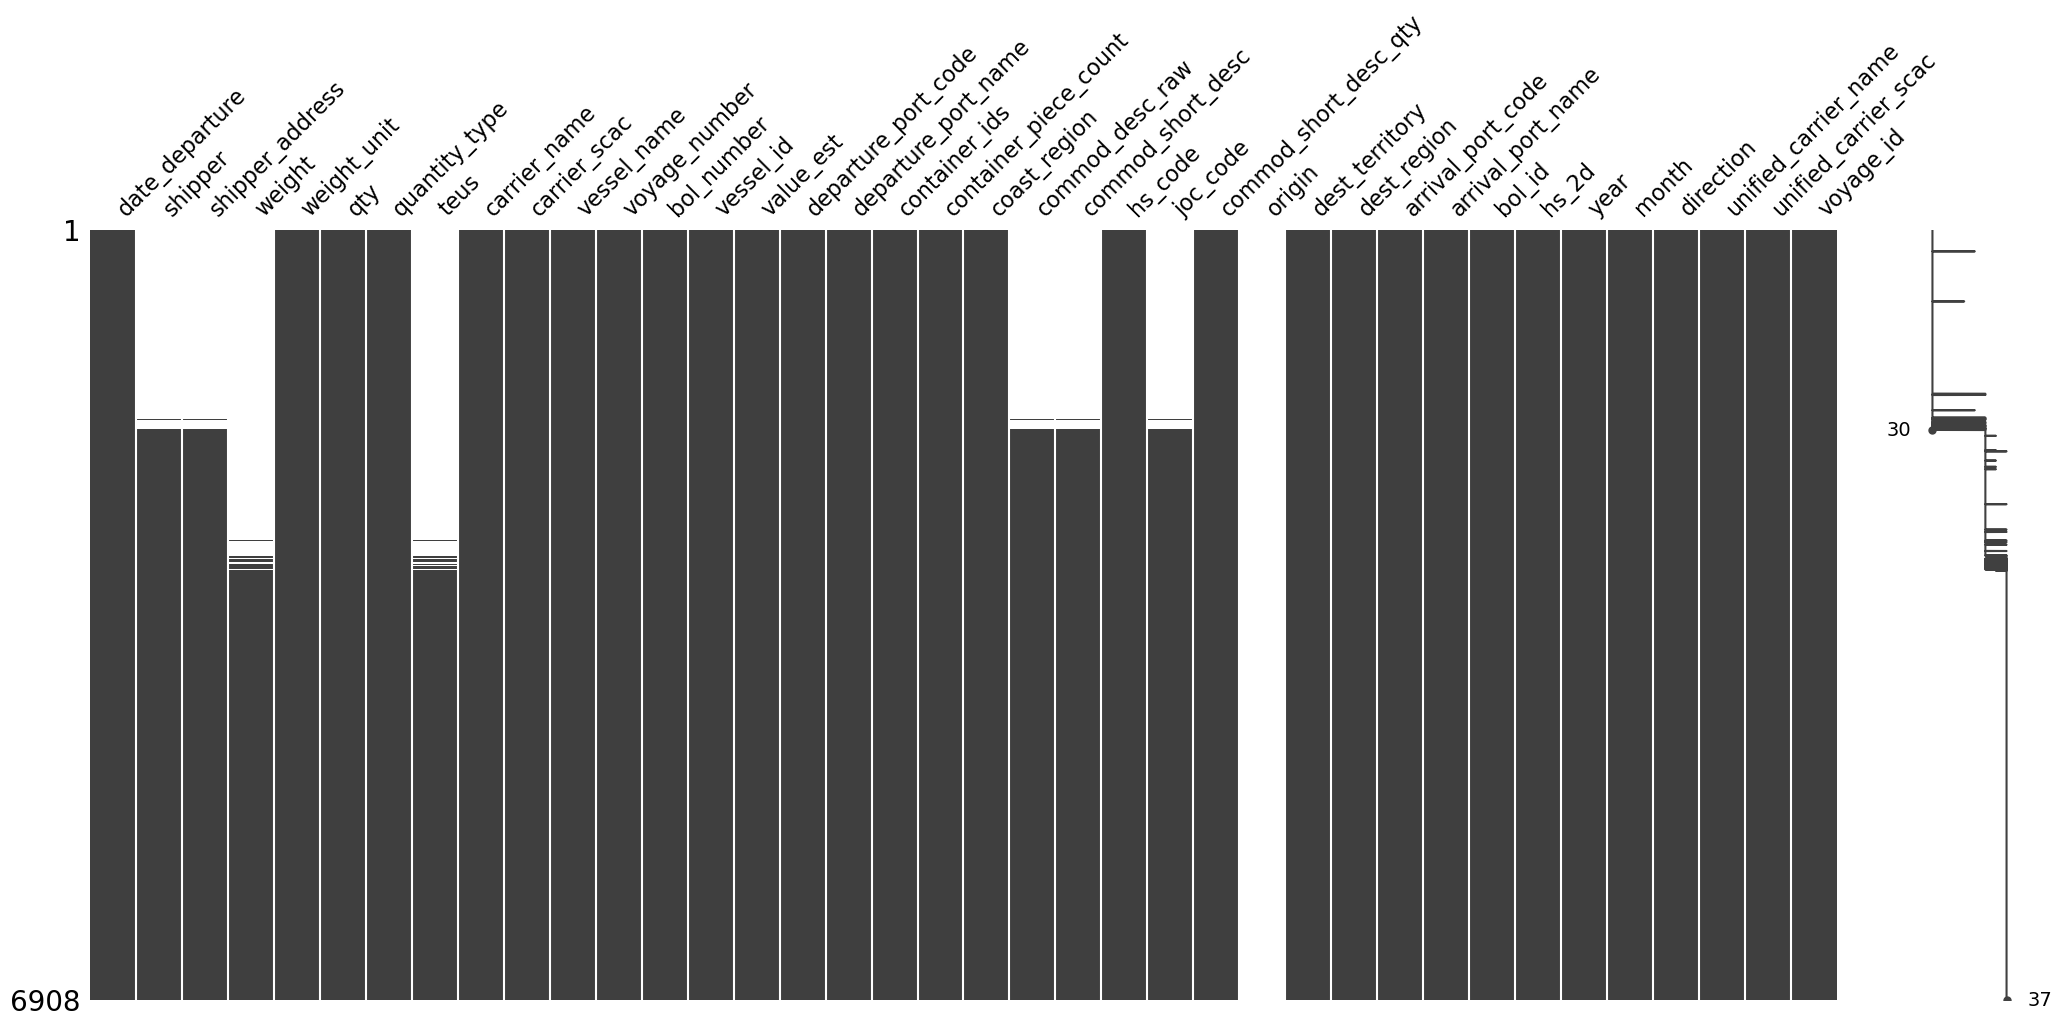

In [8]:
print('Missing Values Matrix for Exports. \nThe vertical axis corresponds to date, with earliest at the top.  \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    exports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_departure').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_departure').sum()
    .sort('date_departure')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

In [9]:
print('Missing Values Matrix for Imports. \nThe vertical axis corresponds to date, with earliest at the top. \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    imports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_arrival').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_arrival').sum()
    .sort('date_arrival')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

Missing Values Matrix for Imports. 
The vertical axis corresponds to date, with earliest at the top. 
Note the daily aggregation counts the row as non-null if any value that day is non-null.


### Zero values in TEU and other volume columns

For the time being, we fill the zero (i.e., missing) volume data with the mean from non-zero observations. This step is expected to change as beter metadata is gathered. 

In [37]:
imports_lf = fill_volume(imports_lf)
exports_lf = fill_volume(exports_lf)    

### Missing Vessel and Voyage IDs

Identifying unique vessels and voyages is critical to studying how long each vessel remains in port, how often carriers utilize alliances (e.g., what proportion of a vessel's cargo is from another carrier), and other quality metrics. The issue is especially concerning given the high proportion (~30% in some time periods) of missing data, as can be seen below.

In [5]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_id'),
    exports_lf.select('direction', 'month', 'vessel_id')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time (original data).')

In [6]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_name'),
    exports_lf.select('direction', 'month', 'vessel_name')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_name',
    title='Proportion of Missing Vessel Names over time (original data).')

In [7]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'voyage_id'),
    exports_lf.select('direction', 'month', 'voyage_id')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='voyage_id',
    title='Proportion of Missing Voyage IDs over time (original data).')

## Primary Carrier

For any given voyage, we assign primary carrier based on the proportion of TEUs from each carrier imported/exported on that voyage (max proportion is primary carrier). 

In [38]:
def add_primary_carrier(lf):
    '''ad hoc function to find primary carrier for each voyage and indicate cargo sharing'''
    lf = (
        lf.with_columns(
            pl.col('teus').sum()
            .over('voyage_id', 'unified_carrier_scac')
            .alias('sum_teus')
            )
        .with_columns(
            pl.col('unified_carrier_scac')
            .sort_by('sum_teus', descending=True)
            .drop_nulls().first()
            .over('voyage_id')
            .alias('primary_scac')
            )
        #add bool col if bol is from primary carrier
        .with_columns(
            (pl.col('unified_carrier_scac')==pl.col('primary_scac'))
            .alias('primary_cargo')
            )
    )
    return lf

def sharing_over_time_plotly(data_lf, group_var, include_missing_voyages=True, limit=10, title=False):
    '''
    Plots proportion of shared cargo over time (months) by group_var.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_var - str - the name of the column by which to group
        include_missing_voyages - bool - default=True, when False, drops missing voyages
        title (default=False) - str - the title of the graph
    OUTPUT:
        a plotly express figure
    DEPENDS ON:
        polars
        plotly express 
    '''
    if not include_missing_voyages:
        df = data_lf.drop_nulls('voyage_id')
    else:
        df = data_lf
    
    df = (
        #select relevant columns
        df.select([group_var, 'month', 'primary_cargo', 'teus'])
        #sum teus over each group-month-shared 
        .group_by(group_var, 'month')
        .agg(
            (pl.col('teus')*pl.col('primary_cargo')).sum().alias('total_primary'),
            pl.col('teus').sum().alias('total_teus')
        )
        #create proportion shared
        .with_columns((1-(pl.col('total_primary')/pl.col('total_teus'))).alias('prop_shared'))
        #cast group col to string to allow sensible ordering of legend
        .cast({group_var:pl.Utf8})
        #sort by date (to allow proper visualization of lines) and group (for legend ordering) 
        .sort('month')
    ).collect()

    #limit categories
    top_groups = (
        data_lf.group_by(group_var)
        .agg(pl.col('teus').sum())
        .sort('teus', descending=True)
        .select(group_var)
        .limit(limit)
        .collect()
        .to_series()
        .cast(pl.Utf8)
    )
    
    #plot
    fig = px.line(
        data_frame=df.filter(pl.col(group_var).is_in(top_groups)).with_columns(pl.col('month').str.to_datetime('%Y%m')),
        x='month', y='prop_shared',
        color=group_var,
        title= 'Proportion of shared cargo over time.' if not title else title,
        labels={
            'prop_shared':'Proportion of cargo from non-primary carrier',
            'month':'Month'
        }
    )
    fig.show()

In [39]:
#add primary carrier and shared cargo columns to lfs
imports_lf = add_primary_carrier(imports_lf)
exports_lf = add_primary_carrier(exports_lf)

In [40]:
lf = pl.concat([imports_lf,exports_lf], how='diagonal')

sharing_over_time_plotly(
    data_lf=lf,
    group_var='direction')

In [11]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='departure_port_name',
    title='Proportion of shared cargo over time (Top 10 export ports by total TEUs).')

In [12]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='departure_port_name',
    include_missing_voyages=False,
    title='Proportion of shared cargo over time (Top 10 export ports by total TEUs).')

In [29]:
#create route_id column
imports_lf = (
    imports_lf.with_columns(
        (pl.col('departure_port_code').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8))
        .cast(pl.Categorical)
        .alias('route_id')
        ))
exports_lf = (
    exports_lf.with_columns(
        (pl.col('departure_port_code').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8))
        .cast(pl.Categorical)
        .alias('route_id')
        ))

In [30]:
#assign port names to routes
def get_route_names(lf):
    '''ad hoc function to get route names from route_id'''
    lf = (
        lf
        .with_columns(
            pl.col('departure_port_name').drop_nulls().mode().first().over('route_id').alias('best_departure_port_name'),
            pl.col('arrival_port_name').drop_nulls().mode().first().over('route_id').alias('best_arrival_port_name')
        )
        .with_columns(
            (pl.col('best_departure_port_name').cast(pl.Utf8)+' — '+pl.col('best_arrival_port_name').cast(pl.Utf8))
            .str.to_titlecase()
            .cast(pl.Categorical)
            .alias('route_name')
        )
        .drop('best_departure_port_name', 'best_arrival_port_name')
    )
    return lf

imports_lf = get_route_names(imports_lf)
exports_lf = get_route_names(exports_lf)

In [15]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='route_name',
    include_missing_voyages=False,
    title='Proportion of shared cargo over time (Top 10 export routes by total TEUs).')

In [16]:
sharing_over_time_plotly(
    data_lf=imports_lf,
    group_var='route_name',
    title='Proportion of shared cargo over time (Top 10 import routes by total TEUs).')

In [41]:
sharing_over_time_plotly(
    data_lf=imports_lf,
    group_var='primary_scac',
    include_missing_voyages=False,
    title='Proportion of shared cargo over time (Top 10 Primary Carriers by total TEUs imported).')

In [32]:
#filter by MSC and Maersk controlled voyages, unifying associated SCAC codes
lf = (
    imports_lf.filter(
        pl.col('primary_scac').is_in(['MEDU','MAEU']),
        pl.col('unified_carrier_scac').is_in(['MEDU','MAEU'])
    )
)
sharing_over_time_plotly(
    data_lf=lf,
    group_var='route_name',
    include_missing_voyages=False,
    title='Proportion of shared cargo over time for MSC and Maersk vessels (Top 10 import routes by total TEUs).')


In [33]:
#filter by MSC and Maersk controlled voyages, unifying associated SCAC codes
lf = (
    exports_lf.filter(
        pl.col('primary_scac').is_in(['MEDU','MAEU']),
        pl.col('unified_carrier_scac').is_in(['MEDU','MAEU'])
    )
)
sharing_over_time_plotly(
    data_lf=lf,
    group_var='route_name',
    include_missing_voyages=False,
    title='Proportion of shared cargo over time for MSC and Maersk vessels (Top 10 export routes by total TEUs).')

## Days in port

For each arrival, we want to know how many days the ship stays in port before departing. 


In [ ]:
ex_lf = (
    exports_lf.select('voyage_id', 'vessel_id', 'date_departure', 'departure_port_code', 'route_id')
    .rename({'voyage_id':'export_voyage_id'})
    .with_columns((pl.col('date_departure').cast(pl.Utf8)+'_'+pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('departure_port_code').cast(pl.Utf8)).alias('departure_id'))
    )
im_lf = (
    imports_lf.select('voyage_id', 'vessel_id', 'date_arrival', 'arrival_port_code', 'route_id')
    .rename({'voyage_id':'import_voyage_id'})
    .with_columns((pl.col('date_arrival').cast(pl.Utf8)+'_'+pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8)).alias('arrival_id'))
    )

lf = ex_lf.join(im_lf, on='voyage_id')

### 'BULK' Carrier SCAC

Many bols show "BULK" in place of carrier code, and at least some bols also show legitimate carrier names. We'll need to clean this up. Perhaps assign carrier code based on carrier name where possible and null values for the reminder?

## Export Clean data to parquet


In [ ]:
#piers_lf.sink_parquet('data/piers_clean.parquet') -- NOTE the above queries are apparently not supported for sinking at this time. 